In [1]:
from functools import partial
from collections import defaultdict
import pydicom
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

np.warnings.filterwarnings('ignore')

In [2]:
labels = pd.read_csv('stage_2_train_labels.csv')
details = pd.read_csv('stage_2_detailed_class_info.csv')
# duplicates in details just have the same class so can be safely dropped
details = details.drop_duplicates('patientId').reset_index(drop=True)
labels_w_class = labels.merge(details, how='inner', on='patientId')

# Prase Meta-Data from the Dicom Image 

In [3]:
# get lists of all train/test dicom filepaths
train_dcm_fps = glob.glob('stage_2_train_images/*.dcm')
test_dcm_fps = glob.glob('stage_2_test_images/*.dcm')

# read each file into a list (using stop_before_pixels to avoid reading the image for speed and memory savings)
train_dcms = [pydicom.read_file(x, stop_before_pixels=True) for x in train_dcm_fps]
test_dcms = [pydicom.read_file(x, stop_before_pixels=True) for x in test_dcm_fps]

In [4]:
def parse_dcm_metadata(dcm):
    unpacked_data = {}
    group_elem_to_keywords = {}
    # iterating here to force conversion from lazy RawDataElement to DataElement
    for d in dcm:
        pass
    # keys are pydicom.tag.BaseTag, values are pydicom.dataelem.DataElement
    for tag, elem in dcm.items():
        tag_group = tag.group
        tag_elem = tag.elem
        keyword = elem.keyword
        group_elem_to_keywords[(tag_group, tag_elem)] = keyword
        value = elem.value
        unpacked_data[keyword] = value
    return unpacked_data, group_elem_to_keywords

train_meta_dicts, tag_to_keyword_train = zip(*[parse_dcm_metadata(x) for x in train_dcms])
test_meta_dicts, tag_to_keyword_test = zip(*[parse_dcm_metadata(x) for x in test_dcms])

In [5]:
#Using the easily interpretable keyword instead of the DICOM tag (group, element) for column names. 
#However, the DICOM tag might be useful for searching online for more info / detailed explanation (e.g. DICOMLookup).
# join all the dicts
unified_tag_to_key_train = {k:v for dict_ in tag_to_keyword_train for k,v in dict_.items()}
unified_tag_to_key_test = {k:v for dict_ in tag_to_keyword_test for k,v in dict_.items()}

# quick check to make sure there are no different keys between test/train
assert len(set(unified_tag_to_key_test.keys()).symmetric_difference(set(unified_tag_to_key_train.keys()))) == 0

tag_to_key = {**unified_tag_to_key_test, **unified_tag_to_key_train}
tag_to_key




{(8, 5): 'SpecificCharacterSet',
 (8, 22): 'SOPClassUID',
 (8, 24): 'SOPInstanceUID',
 (8, 32): 'StudyDate',
 (8, 48): 'StudyTime',
 (8, 80): 'AccessionNumber',
 (8, 96): 'Modality',
 (8, 100): 'ConversionType',
 (8, 144): 'ReferringPhysicianName',
 (8, 4158): 'SeriesDescription',
 (16, 16): 'PatientName',
 (16, 32): 'PatientID',
 (16, 48): 'PatientBirthDate',
 (16, 64): 'PatientSex',
 (16, 4112): 'PatientAge',
 (24, 21): 'BodyPartExamined',
 (24, 20737): 'ViewPosition',
 (32, 13): 'StudyInstanceUID',
 (32, 14): 'SeriesInstanceUID',
 (32, 16): 'StudyID',
 (32, 17): 'SeriesNumber',
 (32, 19): 'InstanceNumber',
 (32, 32): 'PatientOrientation',
 (40, 2): 'SamplesPerPixel',
 (40, 4): 'PhotometricInterpretation',
 (40, 16): 'Rows',
 (40, 17): 'Columns',
 (40, 48): 'PixelSpacing',
 (40, 256): 'BitsAllocated',
 (40, 257): 'BitsStored',
 (40, 258): 'HighBit',
 (40, 259): 'PixelRepresentation',
 (40, 8464): 'LossyImageCompression',
 (40, 8468): 'LossyImageCompressionMethod'}

In [6]:
# using from_records here since some values in the dicts will be iterables and some are constants
train_df = pd.DataFrame.from_records(data=train_meta_dicts)
test_df = pd.DataFrame.from_records(data=test_meta_dicts)
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
df = pd.concat([train_df, test_df])

In [7]:
df.head(50)

,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ConversionType,HighBit,InstanceNumber,LossyImageCompression,LossyImageCompressionMethod,...,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition,dataset
0,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: PA,1.2.276.0.7230010.3.1.3.8323329.28530.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.28530.15178744...,000000.00,PA,train
1,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: AP,1.2.276.0.7230010.3.1.3.8323329.20023.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.20023.15178744...,000000.00,AP,train
2,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: AP,1.2.276.0.7230010.3.1.3.8323329.4475.151787430...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.4475.151787430...,000000.00,AP,train
3,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: AP,1.2.276.0.7230010.3.1.3.8323329.25090.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.25090.15178744...,000000.00,AP,train
4,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: PA,1.2.276.0.7230010.3.1.3.8323329.9271.151787434...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.9271.151787434...,000000.00,PA,train
5,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: PA,1.2.276.0.7230010.3.1.3.8323329.8679.151787433...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.8679.151787433...,000000.00,PA,train
6,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: AP,1.2.276.0.7230010.3.1.3.8323329.29508.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.29508.15178744...,000000.00,AP,train
7,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: AP,1.2.276.0.7230010.3.1.3.8323329.8838.151787433...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.8838.151787433...,000000.00,AP,train
8,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: PA,1.2.276.0.7230010.3.1.3.8323329.25267.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.25267.15178744...,000000.00,PA,train
9,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: PA,1.2.276.0.7230010.3.1.3.8323329.23301.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.23301.15178744...,000000.00,PA,train


In [8]:
#Cleaning DICOM Metadata and Merging to Tabular Data
# separating PixelSpacing list to single values
df['PixelSpacing_x'] = df['PixelSpacing'].apply(lambda x: x[0])
df['PixelSpacing_y'] = df['PixelSpacing'].apply(lambda x: x[1])
df = df.drop(['PixelSpacing'], axis='columns')

# x and y are always the same
assert sum(df['PixelSpacing_x'] != df['PixelSpacing_y']) == 0

In [9]:
# ReferringPhysicianName appears to just be empty strings
assert sum(df['ReferringPhysicianName'] != '') == 0

# SeriesDescription appears to be 'view: {}'.format(ViewPosition)
set(df['SeriesDescription'].unique())

# so these two columns don't have any useful info and can be safely dropped

{'view: AP', 'view: PA'}

#Initial takeaways
Many of the fields are identical throughout all the samples (probably little to gain from looking into these)
Looks like PatientAge, PatientSex, PixelSpacing, and ViewPosition are the only metadata items with possible value
Wide range of ages
Small number of different Pixel Spacings (maybe relevant in terms of resolution and specific to certain imaging machines or setups?)
2 different view positions

In [10]:
nunique_all = df.aggregate('nunique')
nunique_all

AccessionNumber                    1
BitsAllocated                      1
BitsStored                         1
BodyPartExamined                   1
Columns                            1
ConversionType                     1
HighBit                            1
InstanceNumber                     1
LossyImageCompression              1
LossyImageCompressionMethod        1
Modality                           1
PatientAge                        98
PatientBirthDate                   1
PatientID                      29684
PatientName                    29684
PatientOrientation                 1
PatientSex                         2
PhotometricInterpretation          1
PixelRepresentation                1
ReferringPhysicianName             1
Rows                               1
SOPClassUID                        1
SOPInstanceUID                 29684
SamplesPerPixel                    1
SeriesDescription                  2
SeriesInstanceUID              29684
SeriesNumber                       1
S

In [11]:

# drop constant cols and other two from above
df = df.drop(nunique_all[nunique_all == 1].index.tolist() + ['ReferringPhysicianName', 'SeriesDescription'], axis='columns')

# now that we have a clean metadata dataframe we can merge back to our initial tabular data with target and class info
df = df.merge(labels_w_class, how='left', left_on='PatientID', right_on='patientId')

df['PatientAge'] = df['PatientAge'].astype(int)

In [12]:
# df now has multiple rows for some patients (those with multiple bounding boxes in label_w_class)
# so creating one with no duplicates for patients
df_deduped = df.drop_duplicates('PatientID', keep='first')

ViewPosition
View Position is likely important since it describes the positioning of the patient when the radiograph is taken. PA = posterior-anterior (ray enters back first, so back would be at the 'top' of the image) and AP = anterior-posterior (ray enters chest first). My understanding is that PA would be the desired position for detecting lung opacity, however it frequently can't be done in that way as the patient is to ill to stand (which is required for PA). I think there are several important elements here: the pose of the patient is different (standing vs laying), the image has a different 'view' (back-first vs chest-first) and as such different parts of the body may be occluded or obscured to an extent, image quality itself is probably better in PA.¶
Note: I am not a medical professional so this may be an incorrect or incomplete understanding.

Takeaways from below plots:
Test/Train seems relatively well balanced AP vs PA
AP vs PA have a big shift in the 'Normal' and 'Lung Opacity' classes
Target 1/0 is well split for AP, but for PA there are many more 0s
Gender seems relatively well balanced AP vs PA
Age distributions seem similar AP vs PA
Different pixel spacing AP vs PA (probably due to different location of patient relative to imaging machine)

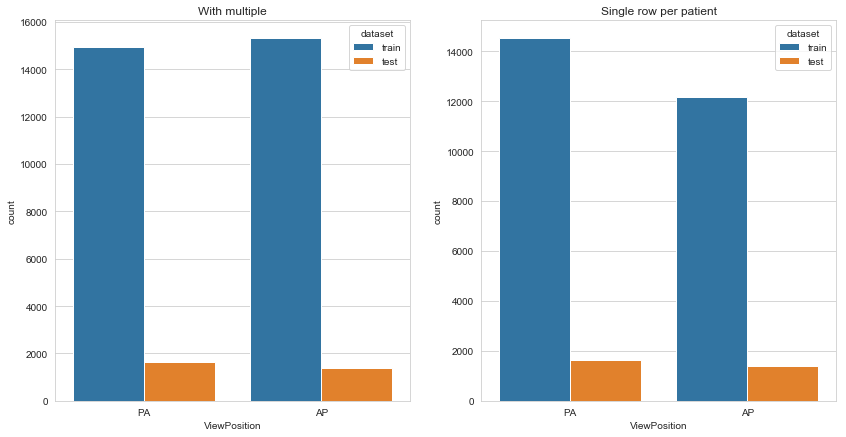

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='dataset', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='ViewPosition', hue='dataset', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

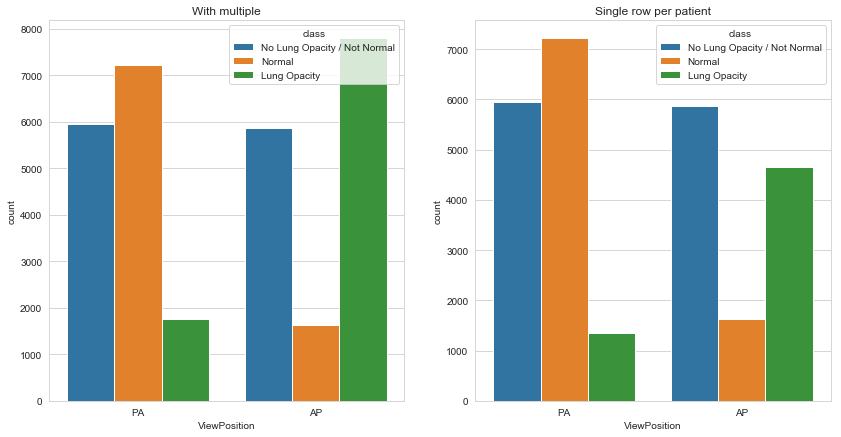

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='class', data=df[df['dataset']=='train'], ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='ViewPosition', hue='class', data=df_deduped[df_deduped['dataset']=='train'], ax=axes[1])
_ = p.set_title('Single row per patient')

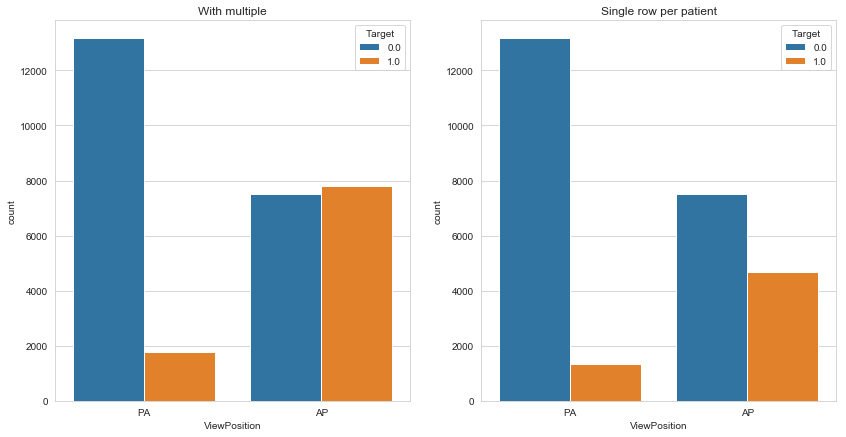

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='Target', data=df[df['dataset']=='train'], ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='ViewPosition', hue='Target', data=df_deduped[df_deduped['dataset']=='train'], ax=axes[1])
_ = p.set_title('Single row per patient')

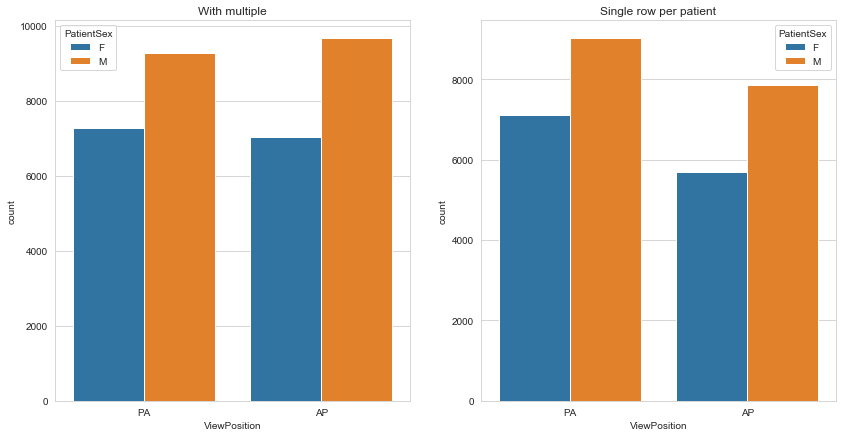

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='ViewPosition', hue='PatientSex', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='ViewPosition', hue='PatientSex', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

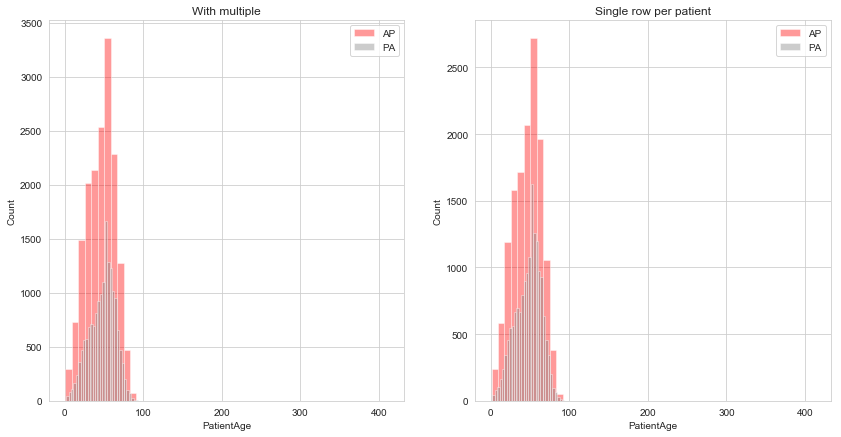

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(df[df['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[0])
p = sns.distplot(df[df['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('With multiple')

p = sns.distplot(df_deduped[df_deduped['ViewPosition']=='AP']['PatientAge'], hist=True, kde=False, color='red', label='AP', ax=axes[1])
p = sns.distplot(df_deduped[df_deduped['ViewPosition']=='PA']['PatientAge'], hist=True, kde=False, color='gray', label='PA', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.legend()
_ = p.set_title('Single row per patient')

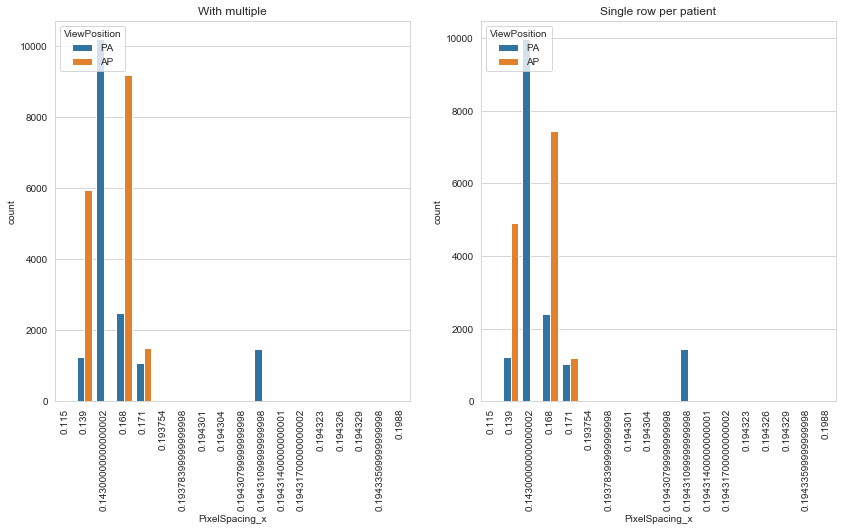

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.countplot(df['PixelSpacing_x'], hue='ViewPosition', data=df, ax=axes[0])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('With multiple')

p = sns.countplot(df_deduped['PixelSpacing_x'], hue='ViewPosition', data=df_deduped, ax=axes[1])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('Single row per patient')

In [19]:
#Viewing the actual images for AP vs PA. The PA images seem much clearer to my untrained eye.


In [20]:
def read_img(patient_id):
    train_fp = 'stage_2_train_images/{}.dcm'.format(patient_id)
    if os.path.exists(train_fp):
        dcm = pydicom.read_file(train_fp)
    else:
        test_fp = 'stage_2_test_images/{}.dcm'.format(patient_id)
        dcm = pydicom.read_file(test_fp)
    return dcm

In [21]:
def plot_grid(df, pid_sample_list, nrows=3, ncols=3, draw_bbox=True, ax_off=True):
    fig = plt.figure(figsize=(16, 12))
    for i in range(nrows * ncols):
        patient_id = pid_sample_list[i]
        img = read_img(patient_id).pixel_array
        ax = fig.add_subplot(nrows, ncols, i + 1)
        plt.imshow(img, cmap='gray')
        ax.set_title(patient_id)
        if ax_off: 
            ax.set_axis_off()
        if draw_bbox:
            bbox_rows = df[df['PatientID'] == patient_id]
            for _, row in bbox_rows.iterrows():
                x, y = row['x'], row['y']
                width, height = row['width'], row['height']
                bbox = patches.Rectangle((x, y), width, height, linewidth=.5, edgecolor='r', facecolor='none')
                ax.add_patch(bbox)
    plt.tight_layout()
    plt.subplots_adjust(wspace=.01, hspace=.01)
    return fig

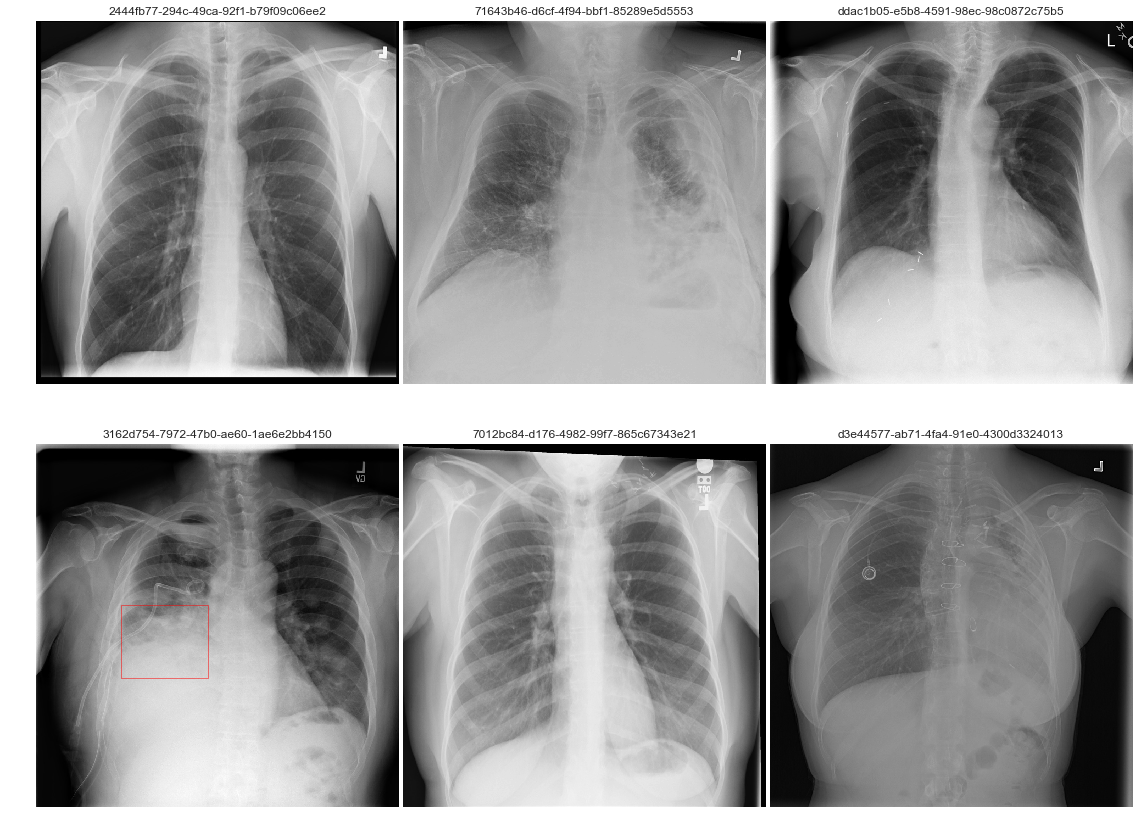

In [22]:
pa_ids = df[df['ViewPosition']=='PA']['PatientID'].sample(20).tolist()
_ = plot_grid(df, pa_ids, nrows=2, ncols=3)

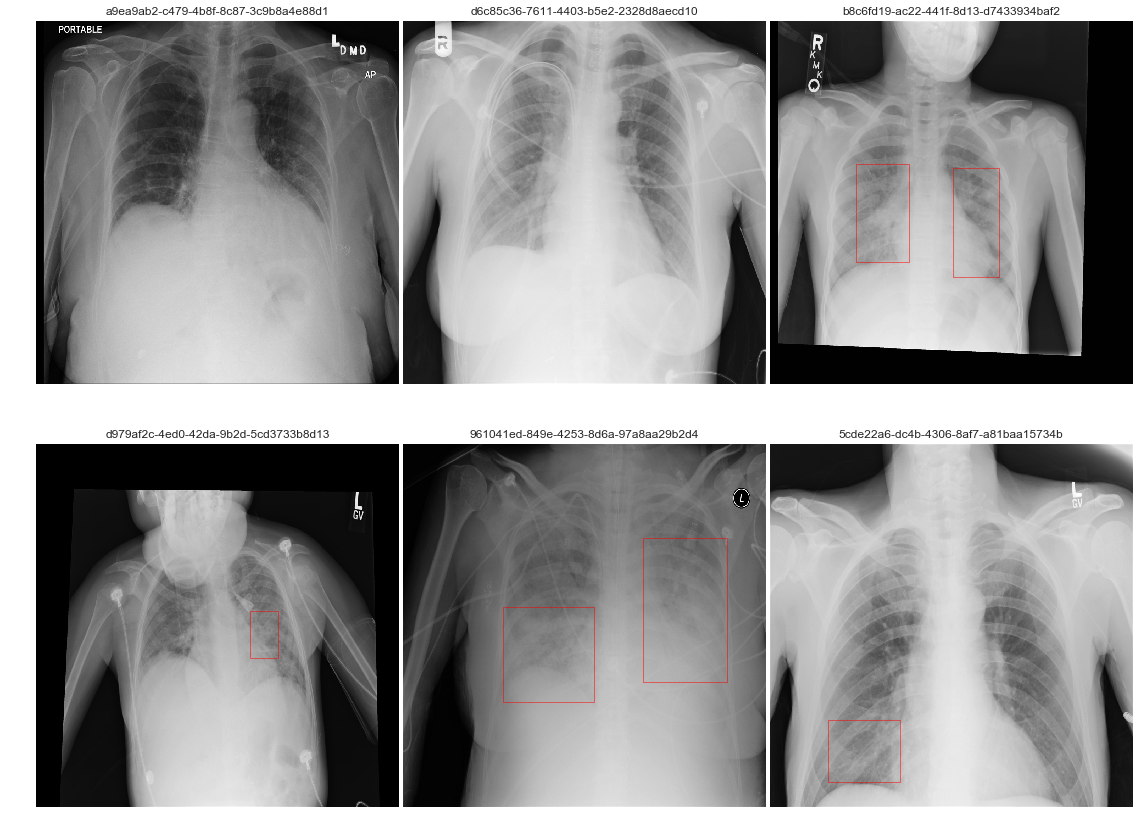

In [23]:
ap_ids = df[df['ViewPosition']=='AP']['PatientID'].sample(20).tolist()
_ = plot_grid(df, ap_ids, nrows=2, ncols=3)

In [24]:
#PatientAge


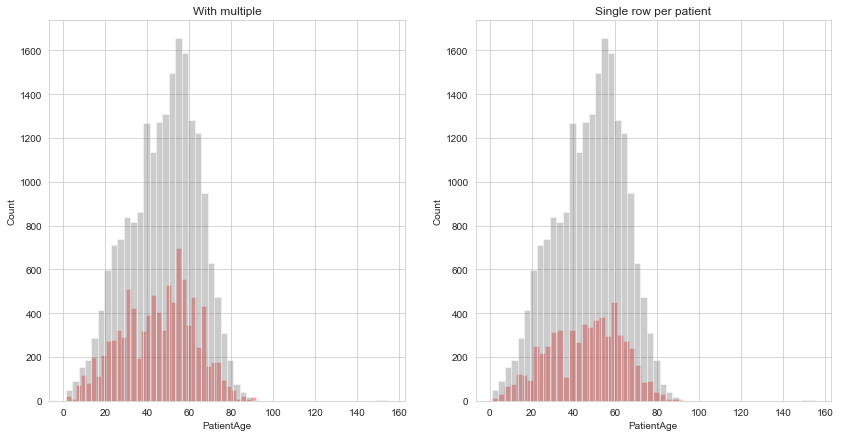

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.distplot(df[df['Target']==1]['PatientAge'], hist=True, kde=False, color='red', label='Target 1', ax=axes[0])
p = sns.distplot(df[df['Target']==0]['PatientAge'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[0])
_ = p.set_ylabel('Count')
_ = p.set_title('With multiple')

p = sns.distplot(df_deduped[df_deduped['Target']==1]['PatientAge'], hist=True, kde=False, color='red', label='Target 1', ax=axes[1])
p = sns.distplot(df_deduped[df_deduped['Target']==0]['PatientAge'], hist=True, kde=False, color='gray', label='Target 0', ax=axes[1])
_ = p.set_ylabel('Count')
_ = p.set_title('Single row per patient')

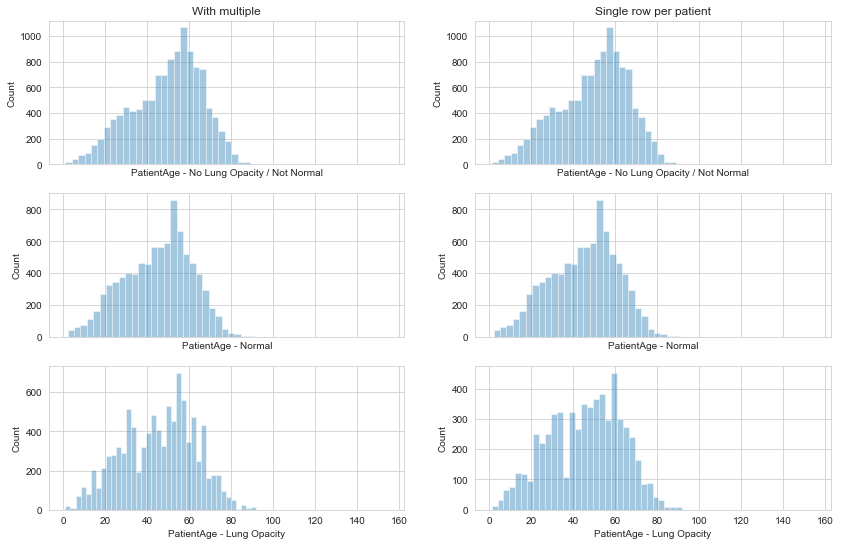

In [26]:

fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)
for i, _class in enumerate(df['class'].dropna().unique()):
    p = sns.distplot(df[df['class']==_class]['PatientAge'], hist=True, kde=False, ax=axes[i, 0])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('With multiple')
    
    p = sns.distplot(df_deduped[df_deduped['class']==_class]['PatientAge'], hist=True, kde=False, ax=axes[i, 1])
    _ = p.set_ylabel('Count')
    _ = p.set_xlabel(f'PatientAge - {_class}')
    if i == 0: p.set_title('Single row per patient')

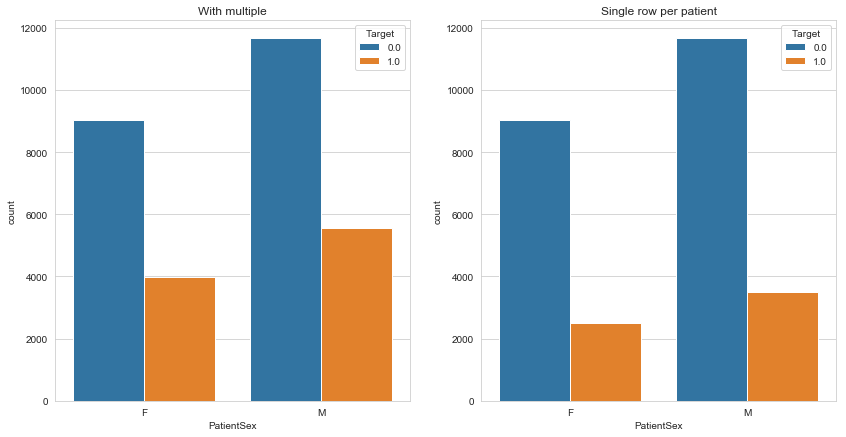

In [27]:
#PatientSex
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='PatientSex', hue='Target', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='PatientSex', hue='Target', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

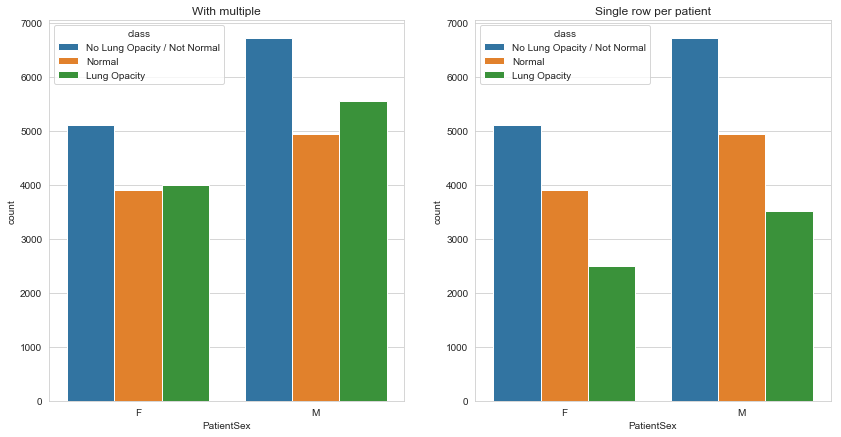

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.countplot(x='PatientSex', hue='class', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.countplot(x='PatientSex', hue='class', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

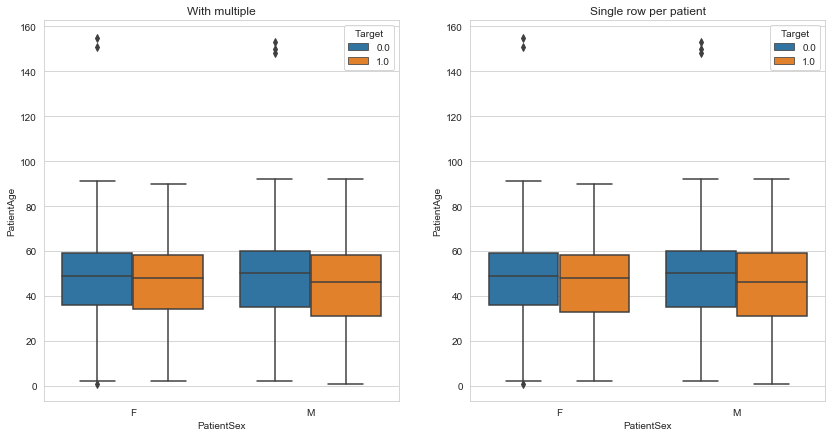

In [29]:

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='Target', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='Target', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

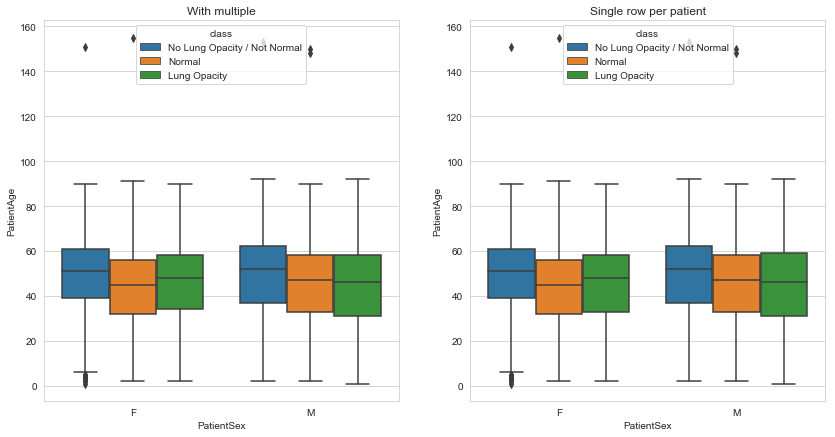

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='class', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='class', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

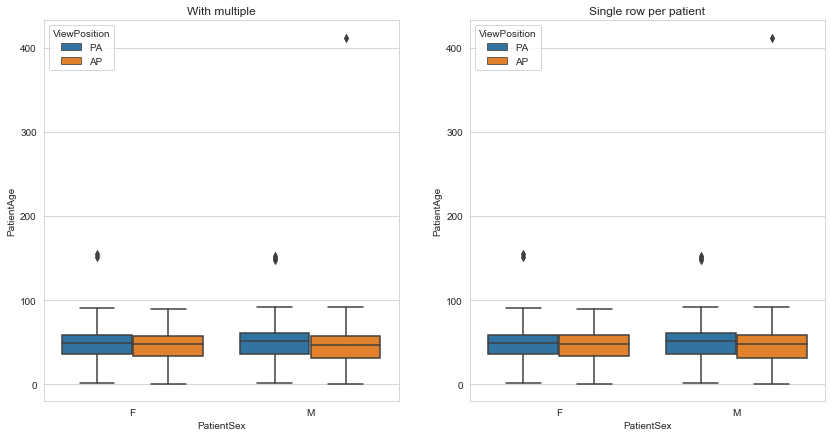

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='ViewPosition', data=df, ax=axes[0])
_ = p.set_title('With multiple')
p = sns.boxplot(x='PatientSex', y='PatientAge', hue='ViewPosition', data=df_deduped, ax=axes[1])
_ = p.set_title('Single row per patient')

In [32]:
#PixelSpacing

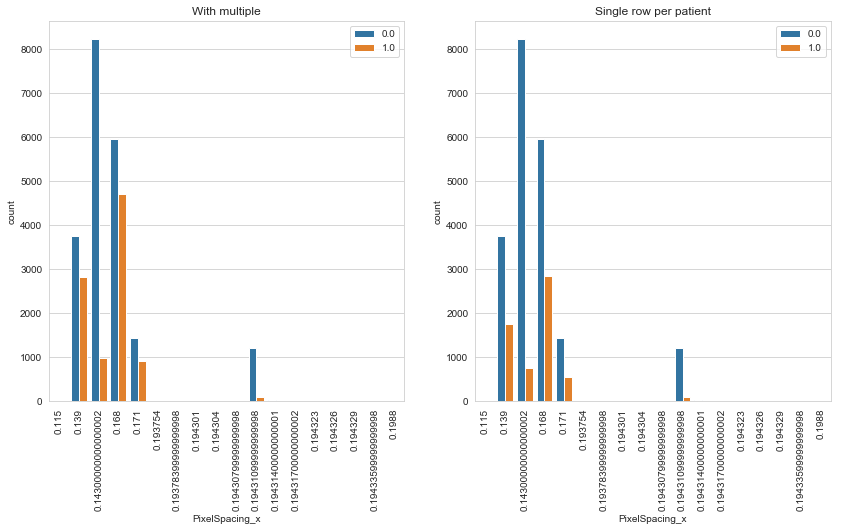

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.countplot(df['PixelSpacing_x'], hue='Target', data=df, ax=axes[0])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('With multiple')
_ = p.legend(loc='upper right')

p = sns.countplot(df_deduped['PixelSpacing_x'], hue='Target', data=df_deduped, ax=axes[1])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('Single row per patient')
_ = p.legend(loc='upper right')

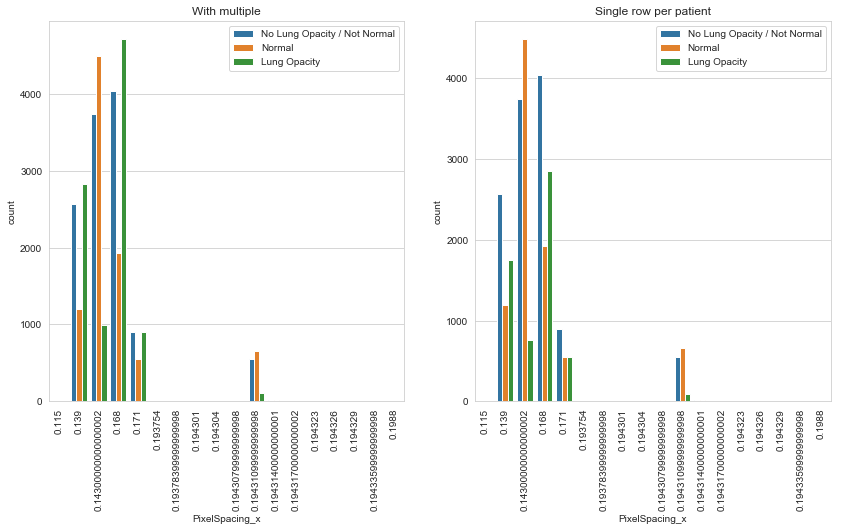

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.countplot(df['PixelSpacing_x'], hue='class', data=df, ax=axes[0])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('With multiple')
_ = p.legend(loc='upper right')

p = sns.countplot(df_deduped['PixelSpacing_x'], hue='class', data=df_deduped, ax=axes[1])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('Single row per patient')
_ = p.legend(loc='upper right')

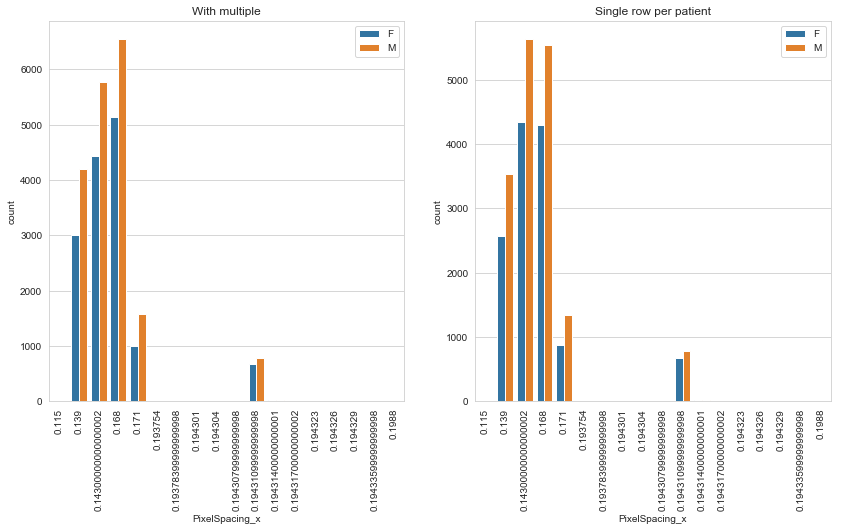

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

p = sns.countplot(df['PixelSpacing_x'], hue='PatientSex', data=df, ax=axes[0])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('With multiple')
_ = p.legend(loc='upper right')

p = sns.countplot(df_deduped['PixelSpacing_x'], hue='PatientSex', data=df_deduped, ax=axes[1])
_ = p.set_xticklabels([x for x in p.get_xticklabels()],rotation=90)
_ = p.set_title('Single row per patient')
_ = p.legend(loc='upper right')

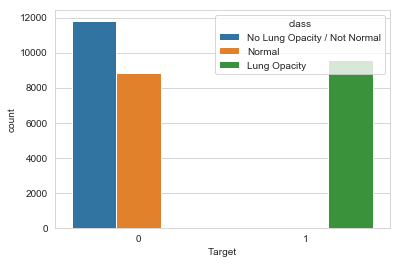

In [36]:
p = sns.countplot(x='Target', hue='class', data=labels_w_class)

In [37]:
# check every row with Target==1 has a bounding box
assert sum(labels_w_class['Target']==1) == sum(~labels_w_class['x'].isnull())

bbox_counts = labels_w_class.groupby('patientId')['Target'].sum()
labels_w_class.index = labels_w_class.patientId
labels_w_class['bbox_counts'] = bbox_counts
labels_w_class = labels_w_class.reset_index(drop=True)

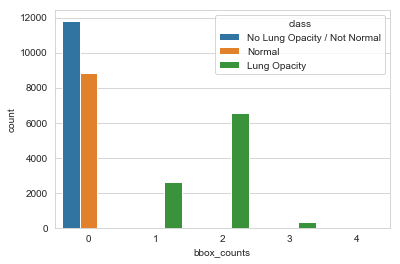

In [38]:
p = sns.countplot(x='bbox_counts', hue='class', data=labels_w_class)

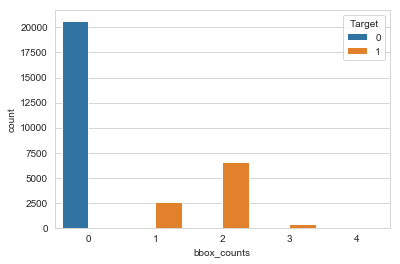

In [39]:
p = sns.countplot(x='bbox_counts', hue='Target', data=labels_w_class)

In [40]:
labels_w_class[['x', 'y', 'width', 'height']].mean()

x         394.047724
y         366.839560
width     218.471376
height    329.269702
dtype: float64

In [41]:
#Bounding Box Data Manipulation
